In [135]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Problem 1: Troubled Waters I

In [136]:
# This is a class that generates instances of problem 1. Each instance is initialised with zero valued Q matrix, zero values nu
# matrix, wind, source, destination, grid dimensions, states, actions, epsilon for epsilon-greedy strategy, discount factor (=1)
# and number of episodes

class Problem1:
    def __init__(self, Q, nu, wind, A, F, N, M, states, actions, eps, alpha, episodes):
        self.Q = Q
        self.nu = nu
        self.wind = wind
        self.A = A
        self.F = F
        self.N = N
        self.M = M
        self.states = states
        self.actions = actions
        self.eps = eps
        self.alpha = alpha
        self.episodes = episodes
    
    # Function that returns the next state given current state and current action. Takes into account wind.
    
    def next_state(self,state,action):
        
        i = (state-1)//self.M # i is the row index
        j = (state-1)%self.M  # j is the column index
        if(action == 1):
            # if we go up 
            # next i = i - 1 - wind
            i = max(0, i-1) 
            i = max(0, i-self.wind[j])
        elif(action == 2):
            j = min(j+1,M-1)
            i = max(0,i-self.wind[j])
        elif(action == 3):
            i = min(i+1,N-1)
            i = max(0, i-self.wind[j])
        else:
            j = max(0,j-1)
            i = max(0,i-self.wind[j])
    
        return int(i*self.M + (j+1)) # State from indices
    
    # Reward for a given state
    
    def reward(self,state):
        if(state == self.F):
            return 0
        else:
            return -1
        
    # This function assigns probabilities to non-optimal directions when the coin toss of epsilon probability results in 
    # exploration. Out of boundary directions and the optimal directions are assigned 0 probability
        
    def set_p(self,state,optimal_action):
        p = np.ones(4)
    
        allowed_actions = 4
    
        p[optimal_action - 1] = 0
        allowed_actions = allowed_actions - 1
    
        i = (state-1)//self.M # i is the row index
        j = (state-1)%self.M  # j is the column index
    
        if(i == 0 and optimal_action != 1):
            allowed_actions = allowed_actions - 1
            p[0] = 0
    
        if(i == self.N-1 and optimal_action != 3):
            allowed_actions = allowed_actions - 1
            p[2] = 0
        
        if(j == 0 and optimal_action != 4):
            allowed_actions = allowed_actions - 1
            p[3] = 0
        
        if(j == self.M-1 and optimal_action != 2):
            allowed_actions = allowed_actions - 1
            p[1] = 0
        
        p = p/allowed_actions
    
        return p
    
    # This function sets the Q values of out of boundary actions for all states to negative infinity so that those are not
    # picked while generating the optimal path
    
    def fix(self):
    
        for x in self.states:
            for u in self.actions:
            
                i = (x-1)//self.M # i is the row index
                j = (x-1)%self.M  # j is the column index
            
            
                if(i == 0 and u == 1):
                    self.Q[x-1,u-1] = -np.inf
                if(i == self.N-1 and u == 3):
                    self.Q[x-1,u-1] = -np.inf
                if(j == 0 and u == 4):
                    self.Q[x-1,u-1] = -np.inf
                if(j == self.M-1 and u == 2):
                    self.Q[x-1,u-1] = -np.inf
    
        return self.Q
    
    # Function that carries out Q learning algorithm, step size function is chosen to be 1/n^0.6 and episodes are run for at
    # most N*M iterations.
    
    def Q_Learning_Discounted_Cost(self):
    
        runs = 0
        
        avg_rewards = []
        
        while(runs < self.episodes):
        
            iters = 0
        
            x = self.A
            
            cur_path = []
            cur_rewards = []
            
            cur_rewards.append(self.reward(x))
    
            while(x != F and iters < self.M*self.N):
        
                Q_copy = np.copy(self.Q)

                pick = random.uniform(0,1)
            
                opt_action = np.argmax(self.Q[x-1]) + 1 # argument is action - 1
            
                if(pick > eps):
                
                    u = opt_action 
                
                    x_next = self.next_state(x,u)
                
                    self.nu[x-1,u-1] = self.nu[x-1,u-1] + 1
                
                    self.Q[x-1,u-1] = Q_copy[x-1,u-1] + (1/(self.nu[x-1,u-1]**(0.6)))*(self.reward(x) + self.alpha*np.max(Q_copy[x_next - 1]) - Q_copy[x-1,u-1])
            
                else:
                
                    p = self.set_p(x,opt_action)
                
                    u = np.random.choice(self.actions,1,replace=False,p=p)[0]
                
                    x_next = self.next_state(x,u)
                
                    self.nu[x-1,u-1] = self.nu[x-1,u-1] + 1
                
                    self.Q[x-1,u-1] = Q_copy[x-1,u-1] + (1/(self.nu[x-1,u-1]**(0.6)))*(self.reward(x) + self.alpha*np.max(Q_copy[x_next - 1]) - Q_copy[x-1,u-1])
                
                cur_rewards.append(self.reward(x_next))
                
                x = x_next
            
                iters = iters + 1
                
            avg_rewards.append(sum(cur_rewards)/len(cur_rewards))
                
            runs = runs + 1
        
        
        self.avg_rewards = avg_rewards
        
        self.Q = self.fix()
    
        current_state = self.A
        path = []
        path.append(self.A)
    
        moves = 0
    
        while(current_state != self.F and moves < self.N*self.M):
            current_state = self.next_state(current_state,np.argmax(self.Q[current_state-1]) + 1)
            path.append(current_state)
            moves = moves + 1
    
    
        self.path = path
        print(path)
        # print(self.Q)
        # print(self.nu)
        
    # Function to start Q learning
        
    def run(self):
        self.Q_Learning_Discounted_Cost()
        
    # Function that prints the grid with the relative value of each state along the path    
    
    def optimal_values(self):
        V = -np.inf*np.ones((self.N,self.M))

        path_set = set(self.path)
        
        for x in self.states:
            if(x in path_set):
                i = (x-1)//self.M # i is the row index
                j = (x-1)%self.M  # j is the column index
                V[i,j] = np.max(self.Q[x-1])
    
        plt.imshow(V)
        plt.show()
        
    # Function that prints the optimal path learnt by the algorithm
        
    def opt_path(self):
        actions_along_path = np.zeros((self.N,self.M), dtype = str)
        opt_actions = np.zeros((self.N,self.M))
        path_set = set(self.path)

        for x in self.states:
            i = (x-1)//self.M
            j = (x-1)%self.M 
            opt_actions[i,j] = np.argmax(self.Q[x-1]) + 1
            if(x in path_set):
                if(opt_actions[i,j] == 1):
                    actions_along_path[i,j] = "N"
                elif(opt_actions[i,j] == 2):
                    actions_along_path[i,j] = "E"
                elif(opt_actions[i,j] == 3):
                    actions_along_path[i,j] = "S"
                else:
                    actions_along_path[i,j] = "W"
            else:
                actions_along_path[i,j] = " "
                
            F_i = (self.F - 1)//self.M
            F_j = (self.F - 1)%self.M
                
            actions_along_path[F_i,F_j] = "F"
        
        print(actions_along_path)

### Finding the optimal path from A to F 

In [137]:
wind = np.ones(12)

wind[0] = 0
wind[1] = 0
wind[2] = 0
wind[11] = 0
wind[7] = 2
wind[8] = 2

states = np.arange(start=1,stop=85,step=1)
actions = np.arange(start=1,stop=5,step=1)

A = 37
F = 46
N = 7
M = 12

eps = 0.1
alpha = 1
episodes = 1000


p1 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, eps, alpha, episodes)

p1.run()


[37, 38, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]


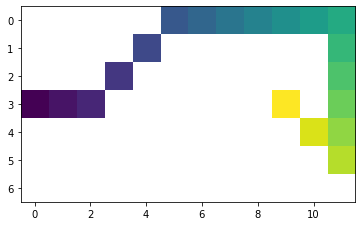

In [138]:
p1.optimal_values()

In [139]:
p1.opt_path()

[[' ' ' ' ' ' ' ' ' ' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 [' ' ' ' ' ' ' ' 'E' ' ' ' ' ' ' ' ' ' ' ' ' 'S']
 [' ' ' ' ' ' 'E' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'S']
 ['E' 'E' 'E' ' ' ' ' ' ' ' ' ' ' ' ' 'F' ' ' 'S']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W' 'S']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']]


### Average Rewards

[37, 38, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]


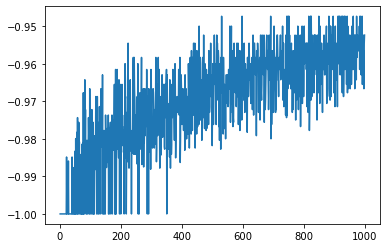

In [140]:
print(p1.path)

plt.plot(np.arange(start = 1, stop = 1001, step = 1), p1.avg_rewards)
plt.show()

### Comparision of different epsilon values

In [154]:
e1 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.1, alpha, 800)
e2 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.2, alpha, 800)
e3 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.3, alpha, 800)
e4 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.4, alpha, 800)
e5 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.5, alpha, 800)
e6 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.6, alpha, 800)
e7 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.7, alpha, 800)
e8 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.8, alpha, 800)
e9 = Problem1(np.zeros((84,4)), np.zeros((84,4)), wind, A, F, N, M, states, actions, 0.9, alpha, 800)




e1.run()
e2.run()
e3.run()
e4.run()
e5.run()
e6.run()
e7.run()
e8.run()
e9.run()

[37, 38, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]
[37, 25, 13, 14, 15, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]
[37, 49, 50, 38, 26, 27, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]
[37, 38, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]
[37, 38, 39, 51, 40, 29, 18, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]
[37, 38, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]
[37, 38, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]
[37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37, 25, 37]
[37, 38, 39, 28, 17, 6, 7, 8, 9, 10, 11, 12, 24, 36, 48, 60, 72, 59, 46]


## Problem 2: Troubled Waters II

In [155]:
# This is a class that generates instances of problem 2. Each instance is initialised with zero valued Q matrix, zero values nu
# matrix, pirates, source, destination, grid dimensions, states, actions, epsilon for epsilon-greedy strategy, discount factor (=1)
# and number of episodes

class Problem2:
    def __init__(self, Q, nu, pirates, A, F, N, M, states, actions, eps, alpha, episodes):
        self.Q = Q
        self.nu = nu
        self.pirates = pirates
        self.A = A
        self.F = F
        self.N = N
        self.M = M
        self.states = states
        self.actions = actions
        self.eps = eps
        self.alpha = alpha
        self.episodes = episodes
        
    # This function assigns probabilities to non-optimal directions when the coin toss of epsilon probability results in 
    # exploration. Out of boundary directions and the optimal directions are assigned 0 probability.

    def next_state_2(self,state, action):
    # Convert state into grid indices
    
        if(state in self.pirates):
            return self.A
    
        i = (state-1)//self.M # i is the row index
        j = (state-1)%self.M  # j is the column index
        
        if(action == 1):
            i = max(0, i-1) 
            # i = max(0, i-wind[j])
        elif(action == 2):
            j = min(j+1,self.M-1)
            # i = max(0,i-wind[j])
        elif(action == 3):
            i = min(i+1,self.N-1)
            # i = max(0, i-wind[j])
        else:
            j = max(0,j-1)
            # i = max(0,i-wind[j])
    
        return int(i*self.M + (j+1)) # State from indices
    
    # Function that gives the reward associated with a state
    
    def reward_2(self,state):
        if state in self.pirates:
            return -100
        elif(state == self.F):
            return 0
        else:
            return -1    
        
    # Same as in problem 1, this function assigns probabilities to non-optimal directions when the coin toss of 
    # epsilon probability results in exploration. Out of boundary directions and the optimal directions are 
    # assigned 0 probability
         
    def set_p(self,state,optimal_action):
        p = np.ones(4)
    
        allowed_actions = 4
    
        p[optimal_action - 1] = 0
        allowed_actions = allowed_actions - 1
    
        i = (state-1)//self.M # i is the row index
        j = (state-1)%self.M  # j is the column index
    
        if(i == 0 and optimal_action != 1):
            allowed_actions = allowed_actions - 1
            p[0] = 0
    
        if(i == self.N-1 and optimal_action != 3):
            allowed_actions = allowed_actions - 1
            p[2] = 0
        
        if(j == 0 and optimal_action != 4):
            allowed_actions = allowed_actions - 1
            p[3] = 0
        
        if(j == self.M-1 and optimal_action != 2):
            allowed_actions = allowed_actions - 1
            p[1] = 0
        
        p = p/allowed_actions
    
        return p
    
    # Same as in problem 1, this function sets out of bounds actions Q values to negative infinity
    
    def fix(self):
    
        for x in self.states:
            for u in self.actions:
            
                i = (x-1)//self.M # i is the row index
                j = (x-1)%self.M  # j is the column index
            
            
                if(i == 0 and u == 1):
                    self.Q[x-1,u-1] = -np.inf
                if(i == self.N-1 and u == 3):
                    self.Q[x-1,u-1] = -np.inf
                if(j == 0 and u == 4):
                    self.Q[x-1,u-1] = -np.inf
                if(j == self.M-1 and u == 2):
                    self.Q[x-1,u-1] = -np.inf
    
        return self.Q

    # Function that carries out Q learning algorithm, step size function is chosen to be 1/n^0.6 and episodes are run for at
    # most N*M iterations. Stores average rewards for every episode and the actual path taken by the agent every 10 episodes.

    def Q_Learning_Discounted_Cost_2(self):
        
        runs = 0
        
        avg_rewards = []
        
        all_paths = []
        
        while(runs < self.episodes):
            
            path_taken = []
    
            iters = 0
        
            x = self.A
            
            cur_path = []
            cur_rewards = []
            
            cur_rewards.append(self.reward_2(x))
            path_taken.append(x)
    
            while(x != self.F and iters < self.N*self.M):
            
                Q_copy = np.copy(self.Q)
                
                pick = random.uniform(0,1)
            
                opt_action = np.argmax(self.Q[x-1]) + 1 # argument is action - 1
            
                if(pick > eps):
                
                    u = opt_action 
                
                    x_next = self.next_state_2(x,u)
                
                    self.nu[x-1,u-1] = self.nu[x-1,u-1] + 1
                
                    self.Q[x-1,u-1] = Q_copy[x-1,u-1] + (1/(self.nu[x-1,u-1]**(0.6)))*(self.reward_2(x) + self.alpha*np.max(Q_copy[x_next - 1]) - Q_copy[x-1,u-1])
            
                else:
                
                    p = self.set_p(x,opt_action)
                
                    u = np.random.choice(self.actions,1,replace=False,p=p)[0]
                
                    x_next = self.next_state_2(x,u)
                
                    self.nu[x-1,u-1] = self.nu[x-1,u-1] + 1
                
                    self.Q[x-1,u-1] = Q_copy[x-1,u-1] + (1/(self.nu[x-1,u-1]**(0.6)))*(self.reward_2(x) + self.alpha*np.max(Q_copy[x_next - 1]) - Q_copy[x-1,u-1])
                
                cur_rewards.append(self.reward_2(x_next))
                path_taken.append(x_next)
                
                x = x_next
                
                iters = iters + 1
            
            avg_rewards.append(sum(cur_rewards)/len(cur_rewards))

            
            if(runs%10 == 0):
                all_paths.append(path_taken)
                
            runs = runs + 1
            
    
        self.avg_rewards = avg_rewards
        self.all_paths = all_paths
        self.Q = self.fix()
    
        current_state = A
        path = []
        path.append(A)
    
        moves = 0
    
        while(current_state != self.F and moves < self.N*self.M):
            current_state = self.next_state_2(current_state,np.argmax(self.Q[current_state-1]) + 1)
            path.append(current_state)
            moves = moves + 1
    
        self.path = path
        
        
    def run(self):
        self.Q_Learning_Discounted_Cost_2()
        
    # Prints the optimal values along the path
        
    def optimal_values(self):
        V = np.zeros((self.N,self.M))

        for x in self.states:
            i = (x-1)//self.M # i is the row index
            j = (x-1)%self.M  # j is the column index
            V[i,j] = np.max(self.Q[x-1])
    
        plt.imshow(V)
        plt.show()
    
    
    # Function to print the optimal path    
    
    def opt_path(self):
        actions_along_path = np.zeros((self.N,self.M), dtype = str)
        opt_actions = np.zeros((self.N,self.M))
        path_set = set(self.path)

        for x in self.states:
            i = (x-1)//self.M
            j = (x-1)%self.M 
            opt_actions[i,j] = np.argmax(self.Q[x-1]) + 1
            if(x in path_set):
                if(opt_actions[i,j] == 1):
                    actions_along_path[i,j] = "N"
                elif(opt_actions[i,j] == 2):
                    actions_along_path[i,j] = "E"
                elif(opt_actions[i,j] == 3):
                    actions_along_path[i,j] = "S"
                else:
                    actions_along_path[i,j] = "W"
            else:
                actions_along_path[i,j] = " "
                
            F_i = (self.F - 1)//self.M
            F_j = (self.F - 1)%self.M
                
            actions_along_path[F_i,F_j] = "F"
        
        print(actions_along_path)

        

### Learning the optimal policy

In [163]:
f1 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.1, 1, 800)
f2 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.2, 1, 800)
f3 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.3, 1, 800)
f4 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.4, 1, 800)
f5 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.5, 1, 800)
f6 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.6, 1, 800)
f7 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.7, 1, 800)
f8 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.8, 1, 800)
f9 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.9, 1, 800)

f1.run()
f2.run()
f3.run()
f4.run()
f5.run()
f6.run()
f7.run()
f8.run()
f9.run()

print(f1.path)
print(f2.path)
print(f3.path)
print(f4.path)
print(f5.path)
print(f6.path)
print(f7.path)
print(f8.path)
print(f9.path)

[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]
[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]


In [156]:
# Running an instance of the Problem 2 class and observing average rewards


p2 = Problem2(np.zeros((48,4)),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.3, 1, 1000)

p2.run()

print(p2.path)

[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]


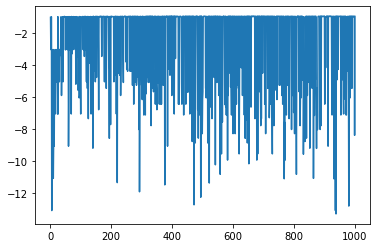

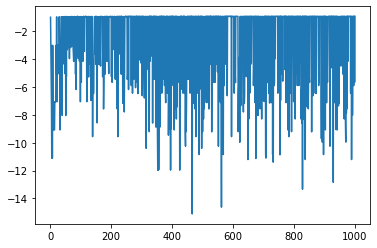

In [157]:
# Plotting average reward over 1000 episodes (during learning)

plt.plot(np.arange(start = 1, stop = 1001, step = 1), p2.avg_rewards)
plt.show()

plt.plot(np.arange(start = 1, stop = 1001, step = 1), p2_second.avg_rewards)
plt.show()

### Average reward using optimal/near optimal policy for 1000 episodes

[37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48]


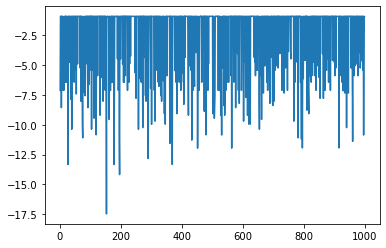

In [168]:
# Plotting average rewards using the converged policy obtained in previous runs

p2_work = Problem2(np.copy(p2.Q),np.zeros((48,4)),set([38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),37,48,4,12, np.arange(start=1,stop= 49,step=1), np.arange(start=1,stop= 5,step=1), 0.3, 1, 1000)

p2_work.run()

print(p2_work.path)

plt.plot(np.arange(start = 1, stop = 1001, step = 1), p2_work.avg_rewards)
plt.show()

In [165]:
p2_work.opt_path()

[[' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 ['N' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' 'F']]


### Printing the path actually taken every 10 episodes

Note that several episodes have a path where the pirates are being visited even though the Q values had supposedly converged in the earlier run. Hence learning has not taken place.

In [167]:
print(p2_work.all_paths)

[[37, 25, 26, 25, 26, 27, 28, 29, 30, 31, 32, 33, 21, 22, 23, 35, 36, 24, 36, 48], [37, 38, 37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48], [37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48], [37, 38, 37, 38, 37, 25, 26, 27, 28, 29, 30, 42, 37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 45, 37, 25, 13, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 24, 36, 48], [37, 25, 26, 27, 28, 29, 28, 29, 30, 31, 32, 20, 21, 22, 23, 24, 36, 48], [37, 38, 37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48], [37, 25, 26, 27, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 36, 48], [37, 25, 26, 27, 28, 29, 30, 42, 37, 25, 26, 27, 28, 29, 30, 31, 32, 31, 32, 33, 32, 31, 32, 33, 34, 35, 36, 48], [37, 25, 26, 27, 15, 3, 2, 3, 4, 5, 6, 7, 8, 9, 21, 22, 23, 24, 36, 48], [37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48], [37, 25, 26, 27, 28, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48], [37, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 48], [37, 25, 26, 27, 28, 29, 30, 31, 32, 44, 37, 38, 37,